# U-Net and Semantic Segmentation

Semantic Segmentation is a computer vision task that inputs an image and would like to output how each pixel on that image can be categorized into one of the potential classes. U-Net is a special convolutional neural network that can be used to output a same-dimensional (same on width and height but different on channel) categorization which tells us what each pixel on the original image is.

This image from (https://www.coursera.org/learn/convolutional-neural-networks/) shows an approximate path for the semantic segmentation task

<br/>

<img src="./images/U_S1.png"/>

And here is an image from the original U-Net paper (https://arxiv.org/pdf/1505.04597.pdf) with a structure of how the network would look like. The network would generally decrease width * height and increase # of channel at first, and in the end gradually decrease # of channel and increase the width * height back to an image size.
<br/>

<img src="./images/U_S2.png" style="zoom:50%;"/>

## Transpose Convolution

Transpose convolution is a type of convolution that is responsible for bring the middle-status, low on width * height but has large # of channel outputs back to high on width * height but decrease in # of channel status.

For example, we can use 2 * 2 (width * height) input and a 3 * 3 kernel, do computation to get a 4 * 4 output.

A specific example is given below. Again, this is from https://www.coursera.org/learn/convolutional-neural-networks.

In this example, we have a 2 * 2 (width * height) input and a 3 * 3 kernel, padding is 1 and stride is 2. We will get a 4 * 4 output.
<br/>

<img src="./images/U_S3.png" style="zoom:50%;"/>

First step is to take left-top value of the input, multiply that by each value in the kernel, paste that on left-top of the output (please note that the padding area's output is ignored). Then, we will step 2 to the right (because stride is 2), use "1" in the input and multiply that with each value in the kernel and paste each result into the second 3 * 3 (green) location.

<br/>

<img src="./images/U_S4.png" style="zoom:50%;"/>

And for parts that results intertwines, we add all the results together. Again, the padded areas are ignored and does not contain values.

<br/>

<img src="./images/U_S5.png" style="zoom:50%;"/>

## U-Net Note Part II

The first part of the U-Net uses normal convolution computation to decrease the width * height and increase # of channels; later layers use transpose convolution to increase width * height and decrease # of channels.

In addition, the U-Net uses "skip connections" from the starting layers to the ending layers with same w * h to provide the later layers more information about the original images.

Here is a another illustration of U-Net. The "rectangle" is showing height * # of channel, which is h * 3 for the most top-left rectangle. Black arrow means a convolutional layer follow a ReLU function.

Firstly (left, most-top) we increase # of channels and keep the width * height same; next we decrease the width * height, increase # of channels (left, 2nd to 5th row). We end up with a low width * height and large # of channel output.

Second part, we use transpose convolution and skip connections between left and right layers (denoted by gray arrows). It is just copy over left layer to the right, concat in channel dimension. Start from the bottom 2nd layer on the right, we increase width * height.

Finally, we are back to the original image's width * height. We add some of other layers and a 1 * 1 convolution (pink arrow) to map to the segmentation. In the end we get width * height * # of classes output.
<br/>

<img src="./images/U_S6.png" style="zoom:30%;"/>



In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import cv2
from torchvision import transforms
from torch.nn import functional as F
import glob
import os
from torch.utils.data import Dataset
import numpy as np
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channel, num_class):
        super(UNet, self).__init__()

        self.n_channels = in_channel
        self.n_classes = num_class

        self.down_sample_1 = self._make_down_sample_layer(in_channel=in_channel, intermediate_channel=64, final_channel=64)
        self.down_sample_2 = self._make_down_sample_layer(in_channel=64, intermediate_channel=128, final_channel=128)
        self.down_sample_3 = self._make_down_sample_layer(in_channel=128, intermediate_channel=256, final_channel=256)
        self.down_sample_4 = self._make_down_sample_layer(in_channel=256, intermediate_channel=512, final_channel=512)
        self.down_sample_5 = self._make_down_sample_layer(in_channel=512, intermediate_channel=1024, final_channel=1024)

        self.up_conv1, self.up_sample_1 = self._make_up_sample_layer(in_channel=1024)
        self.up_conv2, self.up_sample_2 = self._make_up_sample_layer(in_channel=512)
        self.up_conv3, self.up_sample_3 = self._make_up_sample_layer(in_channel=256)
        self.up_conv4, self.up_sample_4 = self._make_up_sample_layer(in_channel=128)
        self.up_conv5, _ = self._make_up_sample_layer(in_channel=64)

        # output would be # of channel = 32
        self.conv1x1_mapping = nn.Conv2d(in_channels=32, out_channels=num_class, kernel_size=1)

    # Left-side down-sampling step
    def _make_down_sample_layer(self, in_channel, intermediate_channel, final_channel):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=intermediate_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(intermediate_channel),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=intermediate_channel, out_channels=final_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(intermediate_channel),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    # Right-side up-sampling step
    def _make_up_sample_layer(self, in_channel):
        final_channel = in_channel // 2
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channel, out_channels=final_channel, kernel_size=2, stride=2),
        ), nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=final_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(final_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=final_channel, out_channels=final_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(final_channel),
            nn.ReLU(inplace=True),
        )

    # In the original paper because of the convolution when doing concat along channel dimension, width * height has
    # slight diff so that we have to crop the left-side output to match the right-side output
    def crop_and_cat(self, left, right):
        c = (left.size()[2] - right.size()[2])
        right = F.pad(right, (c // 2, c - c // 2, c // 2, c - c // 2))
        return torch.cat([right, left], dim=1)

    def forward(self, x):
        out1 = self.down_sample_1(x)
        #print(f"ds1 {out1.shape}")
        out2 = self.down_sample_2(out1)
        #print(f"ds2 {out2.shape}")
        out3 = self.down_sample_3(out2)
        #print(f"ds3 {out3.shape}")
        out4 = self.down_sample_4(out3)
        #print(f"ds4 {out4.shape}")
        out5 = self.down_sample_5(out4)
        #print(f"ds5 {out5.shape}")

        out = self.up_conv1(out5)
        #print(f"uc1 {out.shape}")

        out = self.up_sample_1(self.crop_and_cat(out4, out))
        #print(f"us1 {out.shape}")

        out = self.up_conv2(out)
        #print(f"uc2 {out.shape}")

        out = self.up_sample_2(self.crop_and_cat(out3, out))
        #print(f"us2 {out.shape}")

        out = self.up_conv3(out)
        #print(f"uc3 {out.shape}")

        out = self.up_sample_3(self.crop_and_cat(out2, out))
        #print(f"us3 {out.shape}")

        out = self.up_conv4(out)
        #print(f"uc4 {out.shape}")

        out = self.up_sample_4(self.crop_and_cat(out1, out))
        #print(f"us4 {out.shape}")

        out = self.up_conv5(out)
        #print(f"uc5 {out.shape}")

        out = self.conv1x1_mapping(out)
        #print(f"out {out.shape}")

        return out

## Load Data

We will be using a medical example dataset (https://cuijiahua.com/blog/2020/03/dl-16.html).

In [30]:
# This code is adapted from https://cuijiahua.com/blog/2020/03/dl-16.html

class ISBI_Loader(Dataset):
    def __init__(self, data_path):
        # 初始化函数，读取所有data_path下的图片
        self.data_path = data_path
        self.imgs_path = glob.glob(os.path.join(data_path, 'image/*.png'))

    def augment(self, image, flipCode):
        # 使用cv2.flip进行数据增强，filpCode为1水平翻转，0垂直翻转，-1水平+垂直翻转
        flip = cv2.flip(image, flipCode)
        return flip

    def __getitem__(self, index):
        # 根据index读取图片
        image_path = self.imgs_path[index]
        # 根据image_path生成label_path
        label_path = image_path.replace('image', 'label')
        # 读取训练图片和标签图片
        image = cv2.imread(image_path)
        label = cv2.imread(label_path)
        # 将数据转为单通道的图片
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        image = image.reshape(image.shape[0], image.shape[1], 1)
        label = label.reshape(label.shape[0], label.shape[1], 1)
        # 处理标签，将像素值为255的改为1
        if image.max() > 1:
            image = image / 255
        if label.max() > 1:
            label = label / 255
        # 随机进行数据增强，为2时不做处理
        flipCode = random.choice([-1, 0, 1, 2])
        if flipCode != 2:
            image = self.augment(image, flipCode)
            label = self.augment(label, flipCode)
        image = image.astype(np.float32)
        label = label.astype(np.float32)
        return transforms.ToTensor()(image), transforms.ToTensor()(label)

    def __len__(self):
        # 返回训练集大小
        return len(self.imgs_path)

class ISBI_Test_Loader(Dataset):
    def __init__(self, data_path):
        # 初始化函数，读取所有data_path下的图片
        self.data_path = data_path
        self.imgs_path = glob.glob(os.path.join(data_path, '*.png'))

    def __getitem__(self, index):
        # 根据index读取图片
        image_path = self.imgs_path[index]
        # 读取训练图片和标签图片
        image = cv2.imread(image_path)
        # 将数据转为单通道的图片
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image.reshape(image.shape[0], image.shape[1], 1)
        # 处理标签，将像素值为255的改为1
        if image.max() > 1:
            image = image / 255

        image = image.astype(np.float32)
        return transforms.ToTensor()(image), torch.zeros(image.shape)

    def __len__(self):
        # 返回训练集大小
        return len(self.imgs_path)

In [31]:
batch_size = 4

isbi_dataset_train = ISBI_Loader("./resources/medical/train")
isbi_dataset_test = ISBI_Test_Loader("./resources/medical/test")

train_loader = torch.utils.data.DataLoader(dataset=isbi_dataset_train, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
test_loader = torch.utils.data.DataLoader(dataset=isbi_dataset_test, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))

In [28]:
inputs, classes = next(iter(train_loader))
inputs.shape, classes.shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 1, 512, 512]))

In [7]:
inputs[0]

tensor([[[0.4784, 0.5490, 0.4667,  ..., 0.6588, 0.5569, 0.6118],
         [0.5961, 0.6784, 0.4706,  ..., 0.7176, 0.6745, 0.7412],
         [0.6118, 0.6902, 0.6588,  ..., 0.6784, 0.7176, 0.7137],
         ...,
         [0.5294, 0.6196, 0.7647,  ..., 0.3098, 0.4392, 0.5020],
         [0.6784, 0.7059, 0.7725,  ..., 0.2941, 0.4000, 0.4941],
         [0.5294, 0.5843, 0.6275,  ..., 0.5020, 0.5686, 0.5725]]])

In [8]:
classes[0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

## Train and Test

Here we begin to do the train on dataset using U-Net, and test the result

In [9]:
def train_net(net, criterion, optimizer, epochs=40):
    best_loss = 99999.99
    total_train_len = len(train_loader)

    for epoch in range(epochs):
        avg_train_loss = 0.00
        net.train()
        curr_progress = 0
        for image, label in train_loader:
            curr_progress += 1
            optimizer.zero_grad()
            image, label = image.to(device=device), label.to(device=device)

            # Do Prediction
            pred = net(image)

            # Compute Loss and add to avg loss
            loss = criterion(pred, label)
            avg_train_loss += loss.item()
            print(f'Train Loss {loss.item()} Progress: {(curr_progress / total_train_len):4f}')

            # Update
            loss.backward()
            optimizer.step()

        # Compute batch average loss
        avg_train_loss = avg_train_loss / len(train_loader)
        print(f'epoch {epoch} average train loss {avg_train_loss}')

        if avg_train_loss < best_loss:
            print(f"current best loss: {avg_train_loss}, saving model...")
            best_loss = avg_train_loss
            torch.save(net.state_dict(), './models/unet/best_model.pth')
        else:
            print(f"current loss: {avg_train_loss} larger, reloading model...")
            net.load_state_dict(torch.load('./models/unet/best_model.pth'))

        """


        avg_valid_loss = 0.00
        net.eval()
        for image, label in test_loader:
            image, label = image.to(device=device), label.to(device=device)
            # Do Prediction
            pred = net(image)

            # Compute Loss and add to avg loss
            loss = criterion(pred, label)
            avg_valid_loss += loss.item()

        # Save best model
        if avg_valid_loss < best_loss:
            print(f"current best loss: {avg_valid_loss}, saving model...")
            best_loss = avg_valid_loss
            torch.save(net.state_dict(), './models/unet/best_model.pth')
        else:
            print(f"current loss: {avg_valid_loss} larger, reloading model...")
            net.load_state_dict(torch.load('./models/unet/best_model.pth'))
        """


In [10]:
learning_rate = 0.00001
epochs = 30
weight_decay = 1e-8
momentum = 0.9

model = UNet(in_channel=1, num_class=1)
model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

In [11]:
train_net(model, criterion, optimizer, epochs=epochs)

Train Loss 0.7402322292327881 Progress: 0.125000
Train Loss 0.7309080362319946 Progress: 0.250000
Train Loss 0.7179980874061584 Progress: 0.375000
Train Loss 0.701873779296875 Progress: 0.500000
Train Loss 0.6879832744598389 Progress: 0.625000
Train Loss 0.6742922067642212 Progress: 0.750000
Train Loss 0.6665497422218323 Progress: 0.875000
Train Loss 0.648989200592041 Progress: 1.000000
epoch 0 average train loss 0.6961033195257187
current best loss: 0.6961033195257187, saving model...
Train Loss 0.6440010070800781 Progress: 0.125000
Train Loss 0.6292653679847717 Progress: 0.250000
Train Loss 0.622816801071167 Progress: 0.375000
Train Loss 0.6112373471260071 Progress: 0.500000
Train Loss 0.6086947917938232 Progress: 0.625000
Train Loss 0.587950587272644 Progress: 0.750000
Train Loss 0.5852456092834473 Progress: 0.875000
Train Loss 0.574333667755127 Progress: 1.000000
epoch 1 average train loss 0.6079431474208832
current best loss: 0.6079431474208832, saving model...
Train Loss 0.574014

In [14]:
import matplotlib.pyplot as plt

def see_one_comparison(x, predictions, index):
    x = x[index]
    prediction = predictions[index]

    #prediction[prediction >= 0.5] = 255
    #prediction[prediction < 0.5] = 0

    x = x.squeeze(0)
    prediction = prediction.squeeze(0)

    print(x.shape, prediction.shape)
    rows, columns = 1, 2
    fig = plt.figure(figsize=(10, 7))

    fig.add_subplot(rows, columns, 1)
    plt.imshow(x.cpu().detach().numpy())
    plt.axis('off')
    plt.title("Input")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(prediction.cpu().detach().numpy())
    plt.axis('off')
    plt.title("Prediction")

In [33]:
inputs, classes = next(iter(test_loader))
inputs, classes = inputs.to(device), classes.to(device)
inputs.shape

torch.Size([4, 1, 512, 512])

In [34]:
model.eval()
predictions = model(inputs)

torch.Size([512, 512]) torch.Size([512, 512])


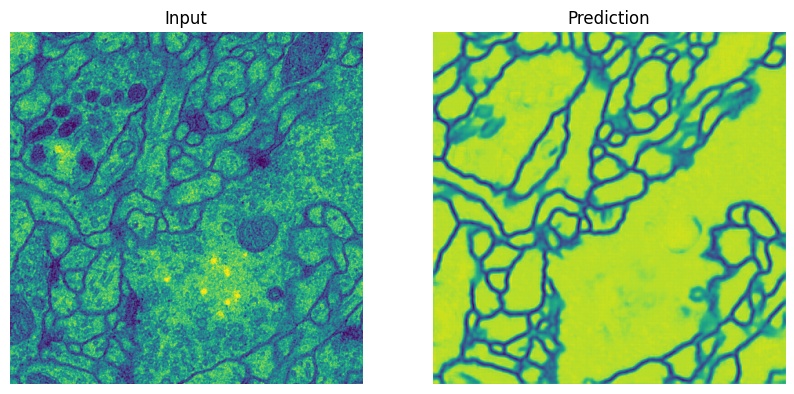

In [37]:
see_one_comparison(inputs, predictions, 1)